# First I need to fetch weather data

In [147]:
import requests
from meteostat import Stations, Daily
from geopy.geocoders import Nominatim
from datetime import datetime
import pandas as pd
from bs4 import BeautifulSoup
import yfinance as yf
import time
import ee


## Here is data using OpenWeatherMap. The problem here is that it doesn't allow me to fetch past weather data!! Only current and forecasting data

## I have therefore installed meteostat which a free python library containing free data, given stationpoints around the world

#### First I need a way to find the name of the city and get the Latitude and longitude data for that city

I downloaded the data from: https://simplemaps.com/data/br-cities


In [24]:
cities = pd.read_csv('./br.csv')

## Brazil's coffee production
#### Since Brazil is a big country I want to narrow down where the production actually happens
According to USDA report on Table 2: https://apps.fas.usda.gov/newgainapi/api/Report/DownloadReportByFileName?fileName=Coffee%20Semi-annual_Brasilia_Brazil_BR2023-0031

We have access to states where most of the coffee farming happens. These states are:
- Mina Gerias with 33.1 Million kg bags in 2023
- Espirito Santo with 18 Million kg bags in 2023 **most of which are not Arabica!!!**
- Sao Paulo with 5.6 Million kg bags in 2023
According to Figure 1, for Arabica beans, farming also happens in:
- Bahia
- Parana
- Espitito Santo

**With that knowledge I will close down on weather data for the cities in those regions!**



In [38]:
admin = cities['admin_name'].value_counts()
admin.head()

admin_name
São Paulo       23
Bahia           19
Maranhão        12
Ceará           11
Minas Gerais     9
Name: count, dtype: int64

In [37]:
regions = ['Minas Gerais','São Paulo','Bahia','Paraná','Espírito Santo']
city = cities[cities['admin_name'].isin(regions)]
city.head()

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,São Paulo,-23.5500,-46.6333,Brazil,BR,São Paulo,admin,23086000.0,12252023.0
2,Belo Horizonte,-19.9167,-43.9333,Brazil,BR,Minas Gerais,admin,5328000.0,2502557.0
5,Salvador,-12.9747,-38.4767,Brazil,BR,Bahia,admin,2418005.0,2418005.0
7,Santos,-23.9369,-46.3250,Brazil,BR,São Paulo,NaN,1897551.0,418608.0
8,Curitiba,-25.4297,-49.2711,Brazil,BR,Paraná,admin,1773733.0,1773733.0


### Here I am downloading the average tempratures and precipitation data for the regions in Brazil where we have most of the coffee produciton. 

I have daily weather data starting from **2019** unitl end of **2023** from the closest stations where data is available in these regions/citites. 

In [121]:
start = datetime(2015, 1, 1)
end = datetime(2023, 12, 31)
#empty dataframe
wdata = pd.DataFrame()
ix = 0

for i in city['city']:
    #The servers used are free but we don't want them to be overloaded with data collection and the code to crash. So I have put a timer between entries!
    time.sleep(0.2)
    name = i
    #Getting latitude and longitude values for each cities in our dataset
    lat = city.loc[city['city'] == i, 'lat'].values[0]
    lng = city.loc[city['city'] == i, 'lng'].values[0]

    #Calling the station
    stations = Stations()
    #Plugging in the lat and lon values for the city
    stations = stations.nearby(lat, lng)
    station = stations.fetch(1)  # Fetch closest station

    # Fetch daily historical data for the specified station and time period
    name = Daily(station, start, end)
    name = name.fetch()
    # Select only the columns for temperature and precipitation
    name = name[['tavg','prcp']]
    #Putting time index as a column so we can merge easily
    name.reset_index(inplace=True)
    #Renaming the columns so we have a better idea which column has the data for which city
    name = name.rename(columns={'tavg':f'tavg_{i}'})
    name = name.rename(columns={'prcp':f'prcp_{i}'})
    #wdata is ann empty dataset. The first time I want it to take the values of the first city, and then after merge new cities into it
    if ix == 0:
        wdata = name.copy()
        ix +=1
    else:
        wdata = wdata.merge(name,right_on='time',left_on='time',how='left')

wdata = wdata.drop_duplicates(subset='time')
# So when we divide the data later both have the dates
wdata = wdata.set_index('time')


#### I want the data to be divided between precepitaion data and average temprature data

In [123]:
prcp_columns = [col for col in wdata.columns if col.startswith('prcp')]
# Create a new DataFrame with these columns
prcp_df = wdata[prcp_columns]

tavg_columns = [col for col in wdata.columns if col.startswith('tavg')]
# Create a new DataFrame with these columns
tavg_df = wdata[tavg_columns]

In [140]:
prcp_df.head(2)

,prcp_São Paulo,prcp_Belo Horizonte,prcp_Salvador,prcp_Santos,prcp_Curitiba,prcp_Guarulhos,prcp_Campinas,prcp_Santo André,prcp_Osasco,prcp_Contagem,...,prcp_Arapoti,prcp_Coração de Maria,prcp_Pojuca,prcp_Jaborandi,prcp_Ituverava,prcp_Ouro Branco,prcp_Retirolândia,prcp_Itinga da Serra,prcp_Perdizes,prcp_Iguaba
time,,,,,,,,,,,,,,,,,,,,,
2018-07-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### To have a bit cleaner data, I will download Google Satelite data, specifically the night light data. I know that cities with higher light density cannot be farm land where coffee are cultivated. So I will remove data from cities close to night light. The remainder has to be farm land. 

I cannot actually go anyfurther and verify that the rural areas actually are farm land and specifically coffee bean farms. For the purposes of this reseach I believe, removing city weather will be enough


In [152]:
ee.Initialize(project='ee-maseehfaizan')

In [161]:
# Load the VIIRS Nighttime Day/Night Band Composites collection
viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG")

# Select an image (e.g., for January 2020)
nighttime_image = viirs.filterDate('2020-01-01', '2020-01-31').median()

# Set visualization parameters
vis_params = {
    'min': 0,
    'max': 60,
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}


In [164]:
import matplotlib.pyplot as plt
from PIL import Image
import urllib.request

url = nighttime_image.getThumbUrl({'min': 0, 'max': 60, 'dimensions': 512, 'format': 'png', 'palette': ['000000', '0000FF', 'FF00FF', '00FFFF', '00FF00', 'FFFF00', 'FF0000']})
image = Image.open(urllib.request.urlopen(url))

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()


EEException: Image.visualize: Cannot provide a palette when visualizing more than one band.

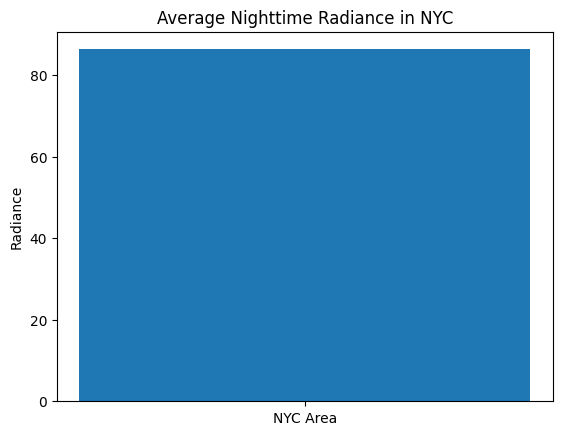

In [160]:
import matplotlib.pyplot as plt

# Assuming result contains the average radiance data
avg_rad_value = result['avg_rad']
plt.bar(['NYC Area'], [avg_rad_value])
plt.title('Average Nighttime Radiance in NYC')
plt.ylabel('Radiance')
plt.show()


#### Coffee Prices specifically Arabica, the coffee beans that is produced in Brazil

I want the data for the same time periodes as the weather data available to me

**Note that these are worldwide coffee prices of *Arabica* and not just Brazil's.** As we have seen before Brazil's produces 40% of world's coffee beans so it must have 

In [125]:
arabica = "KC=F"

price = yf.download(arabica,start,end)
price.reset_index(inplace=True)


price['AVG_Price'] = (price['High'] + price['Low']) / 2
price = price[['Date','AVG_Price','Volume']]


[*********************100%%**********************]  1 of 1 completed


In [132]:
price.head()

,Date,AVG_Price,Volume
0,2015-01-02,163.724998,10303
1,2015-01-05,164.375000,15174
2,2015-01-06,171.724998,18841
3,2015-01-07,177.925003,28145
4,2015-01-08,178.325005,24253
